# Polynomial and Decision Tree Regression on the Pantheon+ dataset

This notebook will showcase using regression models from the scikit-learn module to predict apparent magnitudes using more features than what is done in the visualization notebook. We begin by importing the necessary modules and data.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import os
import sys
sys.path.append('../src')
from preprocessing import preprocess_pantheonp, preprocess_des_data

pantheonpluspath = '../data/Pantheon+SH0ES.dat'

X1,y1 = preprocess_pantheonp(pantheonpluspath)
X_train, X_valid, y_train, y_valid = train_test_split(X1,y1,test_size = 0.3,random_state = 0)

## Polynomial Regression

We can start with the Polynomial regressor. We can set up a simple 3rd degree polynomial regression.

In [3]:
poly1 = PolynomialFeatures(degree = 3, include_bias = False)

poly_features = poly1.fit_transform(X_train)

poly_model = LinearRegression()

poly_model.fit(poly_features,y_train)

ypred = poly_model.predict(poly1.transform(X_valid))
mae3d = mae(y_valid, ypred)
rmse3d = rmse(y_valid,ypred)


print(f'Mean Absolute Error (MAE) for polynomial fit with a 3 degree polynomial : {mae3d}')
print(f'Root Mean Squared Error (RMSE) for polynomial fit with a 3 degree polynomial : {rmse3d}')


Mean Absolute Error (MAE) for polynomial fit with a 3 degree polynomial : 0.6831737322330402
Root Mean Squared Error (RMSE) for polynomial fit with a 3 degree polynomial : 0.9868223374671965


## Decision Tree

We will start with a Decision Tree Regressor.

In [4]:

decTree = DecisionTreeRegressor(random_state = 0)
decTree.fit(X_train,y_train)

y_pred_decTree = decTree.predict(X_valid)

mae_decTree = mae(y_valid,y_pred_decTree)
rmse_decTree = rmse(y_valid,y_pred_decTree)
print(f'MAE for a Decision Tree Regressor : {mae_decTree}')
print(f'RMSE for a Decision Tree Regressor : {rmse_decTree}')

MAE for a Decision Tree Regressor : 0.1592869863013698
RMSE for a Decision Tree Regressor : 0.2199152386640662


Right now, the Decision Tree looks like a better choice to predict the absolute magnitude of Type Ia supernovae from the redshift, stretch and color. We will fit some higher order polynomials to check if the MAE of the polynomial regressor improves.

In [11]:
def polynomial_fitter(X,y,degree):
    poly1 = PolynomialFeatures(degree = degree,include_bias = False)
    poly_features = poly1.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(poly_features,y)
    return poly_model,poly1
    
def maeforpoly(X_train,y_train,X_valid,y_valid,degree):
    # poly1 = PolynomialFeatures(degree = degree,include_bias = False)
    poly_model,poly1 = polynomial_fitter(X_train,y_train,degree)
    ypreds = poly_model.predict(poly1.transform(X_valid))
    return mae(y_valid,ypreds)

def rmseforpoly(X_train,y_train,X_valid,y_valid,degree):
    # poly1 = PolynomialFeatures(degree = degree,include_bias = False)
    poly_model,poly1 = polynomial_fitter(X_train,y_train,degree)
    ypreds = poly_model.predict(poly1.transform(X_valid))
    return rmse(y_valid,ypreds)

degreevals = np.linspace(2,12,11, dtype = 'int64')
for i in degreevals:
    print(f'MAE for a polynomial fit of degree {i} : {maeforpoly(X_train,y_train,X_valid,y_valid,i)}')
    print(f'RMSE for a polynomial fit of degree {i} : {rmseforpoly(X_train,y_train,X_valid,y_valid,i)}\n')

MAE for a polynomial fit of degree 2 : 0.9910553371918874
RMSE for a polynomial fit of degree 2 : 1.2740037693510584

MAE for a polynomial fit of degree 3 : 0.6831737322330402
RMSE for a polynomial fit of degree 3 : 0.9868223374671965

MAE for a polynomial fit of degree 4 : 0.5399037633752826
RMSE for a polynomial fit of degree 4 : 0.8069673923092466

MAE for a polynomial fit of degree 5 : 0.44967846444245024
RMSE for a polynomial fit of degree 5 : 0.7979594990018493

MAE for a polynomial fit of degree 6 : 0.4979908839239662
RMSE for a polynomial fit of degree 6 : 2.1564529116613937

MAE for a polynomial fit of degree 7 : 0.9719012796887476
RMSE for a polynomial fit of degree 7 : 10.190519185600678

MAE for a polynomial fit of degree 8 : 2.810116353956823
RMSE for a polynomial fit of degree 8 : 39.72915557676616

MAE for a polynomial fit of degree 9 : 12.319525100429475
RMSE for a polynomial fit of degree 9 : 212.35397679599305

MAE for a polynomial fit of degree 10 : 82.76626679452838

We can check the performance of the two models in predicting the values of the validation set.

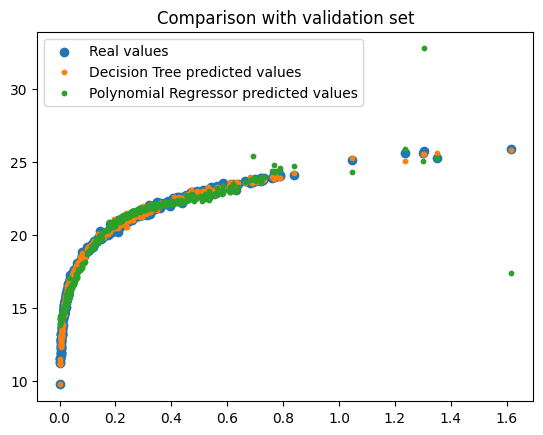

In [6]:
d5fitter,d5transform = polynomial_fitter(X_train,y_train,5)

ypred_d5 = d5fitter.predict(d5transform.transform(X_valid))

plt.scatter(X_valid['zHD'],y_valid, label = 'Real values')
plt.scatter(X_valid['zHD'],y_pred_decTree, label = 'Decision Tree predicted values', s = 10)
plt.scatter(X_valid['zHD'],ypred_d5, label = 'Polynomial Regressor predicted values', s = 10)
plt.title('Comparison with validation set')
plt.legend()


## Validation

We can see that the the fit is best when we choose a polynomial of degree 5 as it gives the least MAE, but the Decision Tree makes beter predictions than even the degree 5 polynomial regressor. But this is from the same Pantheon+ dataset. To validate these models in a more robust manner, we need to test it against a different dataset. For this, I will be using the Dark Energy Survey 5 Year Data release supernova dataset, which contains data of 1829 supernovae.

In [7]:
despath = '../data/DES-data.csv'
X_test,y_test = preprocess_des_data(despath)
decTree2 = DecisionTreeRegressor(random_state = 0)
decTree2.fit(X1,y1)

y_pred_decTree2 = decTree2.predict(X_test)
maetest_decTree2 = mae(y_test,y_pred_decTree2)
rmsetest_decTree2 = rmse(y_test,y_pred_decTree2)

print(f'MAE for Decision Tree with test data : {maetest_decTree2}')
print(f'RMSE for Decision Tree with test data : {rmsetest_decTree2}')

MAE for Decision Tree with test data : 0.2167447785675233
RMSE for Decision Tree with test data : 0.32766545014245635


In [12]:

for i in degreevals:
    print(f'MAE for polynomial fit of degree {i} with test data : {maeforpoly(X1,y1,X_test,y_test,i)}')
    print(f'RMSE for polynomial fit of degree {i} with test data : {rmseforpoly(X1,y1,X_test,y_test,i)}\n')

MAE for polynomial fit of degree 2 with test data : 1.042815292581271
RMSE for polynomial fit of degree 2 with test data : 1.3226903930060956

MAE for polynomial fit of degree 3 with test data : 0.611420687102262
RMSE for polynomial fit of degree 3 with test data : 0.7592872336784319

MAE for polynomial fit of degree 4 with test data : 0.5344639368609961
RMSE for polynomial fit of degree 4 with test data : 0.7111032545295186

MAE for polynomial fit of degree 5 with test data : 0.5424599903285149
RMSE for polynomial fit of degree 5 with test data : 0.8575392568677555

MAE for polynomial fit of degree 6 with test data : 0.5856359710730267
RMSE for polynomial fit of degree 6 with test data : 1.427331554895807

MAE for polynomial fit of degree 7 with test data : 1.071674408338332
RMSE for polynomial fit of degree 7 with test data : 4.435740867375243

MAE for polynomial fit of degree 8 with test data : 2.0632098118930333
RMSE for polynomial fit of degree 8 with test data : 11.58532248347750

We can finally check the predicted values with the real values from the data as well.

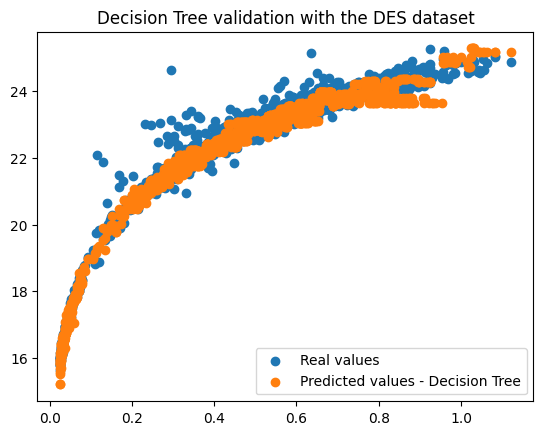

In [9]:
plt.scatter(X_test['zHD'],y_test, label = 'Real values')
plt.scatter(X_test['zHD'],y_pred_decTree2, label = 'Predicted values - Decision Tree')
plt.title('Decision Tree validation with the DES dataset')
plt.legend()

## Conclusion

We can conclude that the Decision Tree Regressor proves to be a better model to predict absolute magnitudes of supernovae from these three features. Polynomial Regression with a polynomial of degree 5 also seem to give really good results.